# Section One: Theoretical Understanding

In practice, stock can be modeled by a stochastic process known as a geometric Brownian motion (GBM). A process is a GBM if it can be modeled by the equation:

                                        𝑑𝑆(𝑡) = 𝜇𝑆(𝑡)𝑑𝑡 + 𝜎𝑆(𝑡)𝑑𝑊𝑡
Where 𝑆(𝑡) is the stock price, 𝜇 is the drift rate, 𝜎 is the volatility, and 𝑊𝑡 is a standard Wiener process. When solving this equation we find:
                                      
$$𝑆(𝑡) = 𝑆(0)𝑒^{(𝜇− \frac{𝜎^2}{2})𝑇+𝜎𝑊_𝑡}$$
                                      
Now this equation by itself isn't very useful and will give a wide range of results, but there are multiple useful applications. 




# Section Two: Setup

As stated above, to estimate the future value of the stock we need to know a few things: the current stock price, the drift rate (average returns), and the volatility. This section will explain how to gather that information.

### Current Stock Price

We will gather stock information from yahoo finance using the yfinance API. We will use numpy and matplotlib.pyplot throughout the workbook.

In [23]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Now decide which stock you want to model, it can be any, but for this example I will use the Netflix, feel free to change it by changing the tickers. Also decide what timeframe you want your data to be from. 

In [13]:
Stock = yf.download(tickers = "NFLX", start = '2018-11-18',end = '2023-11-18', prepost = True,  progress=False)

To calculate the average returns and volatility, we need to know the closing price of the Stock, we will store this in a seperate variable.

In [14]:
Close = Stock["Close"]

Let's graph the closing prices of the S&P 500 index

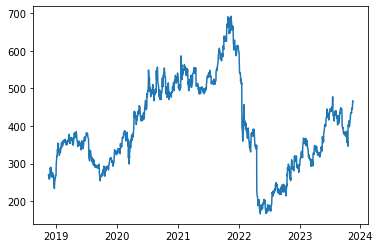

In [15]:
plt.plot(Close)
plt.show()

Now we calculate the mean and volatility of the daily return of the stock.

### Mean and Volatility

In [16]:
returns = []

for i in range(0, len(Close)-1):
    tomorrow = Close[i+1]
    today = Close[i]  
    daily_return = (tomorrow - today)/today
    returns.append(daily_return)
    

mu = np.mean(returns)*250
sigma = np.std(returns)*np.sqrt(250)

/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_99034/4060491708.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tomorrow = Close[i+1]
/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_99034/4060491708.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  today = Close[i]


# Section Three: Euler-Maruyama Method

Although we were able to explicitly solve for the stock price at time t, it is common when dealing with SDEs that you are not able to solve explicitly. When this is the case, we can use the Euler-Maruyama Method to estimate solutions. The Euler-Maruyama Method is an extension of Euler's method for estimating ODEs. First, let x = S(0). Then:

$$𝑥_{𝑖+1} = 𝑥_𝑖 + 𝜇𝑆(𝑡_𝑖)Δ𝑡_{𝑖+1} + 𝜎𝑆(𝑡_{𝑖})Δ𝑊_{𝑖+1}$$

Below is the code for the EMM method, note because we want to estimate the path for an entire year of trading, we use the previous estimation instead of the actual stock price.

In [17]:
import random
def EMM_model(S0,mu, sigma, T, steps):
    h = T/steps
    prices=[]
    t = np.arange(0, T, h)
    x = S0
    for j in range(0, t.size):
        x = x + x * mu * h + x * sigma * random.gauss(0, np.sqrt(h))
        prices.append(x)
    return  prices


Now lets simulate the next calendar year and compare how our EMM simulation compares to the actual closing price. We can compare by graphing the two sets of data against eachother. The EMM simulation is stochastic, so if you run the follwing cell multiple times, you will see multiple different results. 

/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_99034/2677673571.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = Close[len(Close)-1]


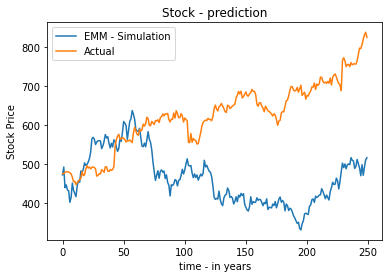

In [34]:
Stock_actual = yf.download(tickers = "NFLX", start = '2023-11-18',end = '2024-11-18', prepost = True,  progress=False)
S0 = Close[len(Close)-1]
simulation = np.array(EMM_model(S0, mu, sigma, 1, 250))

plt.plot(simulation, label= "EMM - Simulation")
plt.plot(np.array(Stock_actual["Close"]), label = "Actual")

plt.xlabel("time - in years")
plt.ylabel("Stock Price")
plt.title('Stock - prediction')

# Add a legend
plt.legend()

plt.show()

# Section Four: Stock Price Equation

Below is the code for the stock price equation given from Section One. This equation is also stochastic, so we see many different answers.

In [19]:
import math as m
num_times = 10
T=1 #years
Prices=[]
for i in range(num_times):
    z = np.random.randn(1)
    Price = S0*m.exp((mu-0.5*sigma*sigma)*T+sigma*m.sqrt(T)*z)
    Prices.append(Price)
print(Prices)

[343.8028897751675, 217.2302980667451, 459.87010602499913, 553.0485117246386, 298.3113925404883, 869.3793827163129, 1113.2230695388735, 230.32381266869106, 825.6454248455659, 417.4491446693841]


/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_99034/1466622.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Price = S0*m.exp((mu-0.5*sigma*sigma)*T+sigma*m.sqrt(T)*z)


# Section Five: Risk Free Option Pricing

The price of an option is derived using risk-neutral valuation, which means we calculate the expected value of the option's payoff as if investors are indifferent to risk. This expected value is then discounted at the risk-free interest rate to account for the time value of money.

### Monte Carlo Simulation

The Monte Carlo method is a simple but powerful idea. It essentially involves running a large number of simulations and then taking the average. The Monte Carlo method with respect to option pricing simulates the value of the underlying asset, which can then be used to price the option. Since the Monte Carlo method can simulate the entire lifetime of an option it is incredibly useful for evaluating more options that are path-dependent

In [53]:
def Monte_Carlo_Sim(S0,K, r,div,sigma,T, steps, numSim):
    sim_steps = steps*T
    h = T/steps
    St = np.zeros(shape=(sim_steps,numSim))
    St[0,] = S0
    for i in range(1,sim_steps):
        for j in range(0,numSim):
            z = np.random.randn(1)
            St[i,j] = St[i-1,j]*m.exp((r-div-0.5*sigma*sigma)*h+sigma*m.sqrt(h)*z)
    sim_stocks = pd.DataFrame(St)
    return sim_stocks


/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_99034/266157500.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  St[i,j] = St[i-1,j]*m.exp((r-div-0.5*sigma*sigma)*h+sigma*m.sqrt(h)*z)


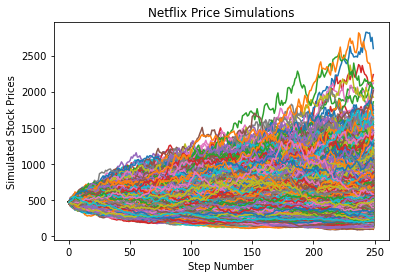

In [58]:
steps =250
K=500
r=.045
T=1
sim_stocks = Monte_Carlo_Sim(S0,K, r,0, sigma, T, steps,10000)
plt.plot(sim_stocks)
plt.title("Netflix Price Simulations")
plt.xlabel("Step Number")
plt.ylabel("Simulated Stock Prices")
plt.show()

### Asian Options

As stated above, the Monte Carlo method is useful for pricing path dependent options, the Asian
option is one such option. The payoff of an Asian option is dependent on the average price of the
underlying asset over the lifetime of the option. Asian options are often used when an underlying
asset is very volatile because the average price of the asset will be less volatile than the actual asset
itself. Below we use the simulated paths above to price the Asian call option.

In [59]:
prices = []
Y = []
for i in range(0,steps):
    prices.append(np.mean(sim_stocks[i])) # Taking the arithmetic mean
    Y.append(max(prices[i]-K,0)*m.exp(-r*T))
arithmetic_opt_price  = np.mean(Y)

print(arithmetic_opt_price)

38.86895977566989
